<a href="https://colab.research.google.com/github/hlybrower/IS-4487-Labs/blob/main/AirQuality_HBrower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import matplotlib as mpl
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree


In [2]:
# import data
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

df_22 = pd.read_csv (r'/content/drive/MyDrive/aqi2022.csv')
df_12 = pd.read_csv (r'/content/drive/MyDrive/aqi2012.csv')


Mounted at /content/drive


In [7]:
# Look at data types
df_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202786 entries, 0 to 202785
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State Name                 202786 non-null  object
 1   county Name                202786 non-null  object
 2   State Code                 202786 non-null  int64 
 3   County Code                202786 non-null  int64 
 4   Date                       202786 non-null  object
 5   AQI                        202786 non-null  int64 
 6   Category                   202786 non-null  object
 7   Defining Parameter         202786 non-null  object
 8   Defining Site              202786 non-null  object
 9   Number of Sites Reporting  202786 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 15.5+ MB


In [8]:
# Filter 2022 for just Utah

df_22_ut= df_22[(df_22['State Name']=='Utah')]

df_22_ut.describe()
     

,State Code,County Code,AQI,Number of Sites Reporting
count,3818.0,3818.000000,3818.000000,3818.000000
mean,49.0,30.114196,48.905972,1.903091
std,0.0,18.429682,15.369855,1.922533
min,49.0,3.000000,2.000000,1.000000
25%,49.0,13.000000,40.000000,1.000000
50%,49.0,35.000000,45.000000,1.000000
75%,49.0,47.000000,53.000000,2.000000
max,49.0,57.000000,177.000000,8.000000


In [9]:
# Filter 2012 for just Utah

df_12_ut= df_12[(df_12['State Name']=='Utah')]

df_12_ut.describe()

,State Code,County Code,AQI,Number of Sites Reporting
count,5065.0,5065.000000,5065.000000,5065.000000
mean,49.0,29.016979,50.623889,1.956762
std,0.0,19.621067,21.091122,1.361100
min,49.0,3.000000,2.000000,1.000000
25%,49.0,9.000000,37.000000,1.000000
50%,49.0,35.000000,46.000000,1.000000
75%,49.0,47.000000,61.000000,2.000000
max,49.0,57.000000,169.000000,6.000000


In [10]:
# Calculate the average AQI for Utah and the rest of the US

utah_aqi_22 = df_22_ut['AQI'].mean()
us_aqi_22 = df_22[df_22['State Name'] != 'Utah']['AQI'].mean()
utah_aqi_12 = df_12_ut['AQI'].mean()
us_aqi_12 = df_12[df_12['State Name'] != 'Utah']['AQI'].mean()

print(f"Average AQI in Utah in 2022: {utah_aqi_22:.2f}")
print(f"Average AQI in the rest of the US in 2022: {us_aqi_22:.2f}")
print(f"Average AQI in Utah in 2012: {utah_aqi_12:.2f}")
print(f"Average AQI in the rest of the US in 2012: {us_aqi_12:.2f}")

Average AQI in Utah in 2022: 48.91
Average AQI in the rest of the US in 2022: 39.39
Average AQI in Utah in 2012: 50.62
Average AQI in the rest of the US in 2012: 44.10


In [14]:
# Determine the best and worst seasons for air quality in Utah
df_22_ut['Month'] = pd.to_datetime(df_22_ut['Date']).dt.month
df_12_ut['Month'] = pd.to_datetime(df_12_ut['Date']).dt.month
utah_22_seasons = df_22_ut.groupby('Month')['AQI'].mean()
utah_12_seasons = df_12_ut.groupby('Month')['AQI'].mean()

best_season_22 = utah_22_seasons.idxmin()
worst_season_22 = utah_22_seasons.idxmax()
best_season_12 = utah_12_seasons.idxmin()
worst_season_12 = utah_12_seasons.idxmax()

print(f"Best season for air quality in Utah in 2022: {best_season_22}")
print(f"Worst season for air quality in Utah in 2022: {worst_season_22}")
print(f"Best season for air quality in Utah in 2012: {best_season_12}")
print(f"Worst season for air quality in Utah in 2012: {worst_season_12}")

Best season for air quality in Utah in 2022: 11
Worst season for air quality in Utah in 2022: 7
Best season for air quality in Utah in 2012: 10
Worst season for air quality in Utah in 2012: 5


<ipython-input-14-4c4c9cd0dd32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22_ut['Month'] = pd.to_datetime(df_22_ut['Date']).dt.month
<ipython-input-14-4c4c9cd0dd32>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12_ut['Month'] = pd.to_datetime(df_12_ut['Date']).dt.month


In [16]:
# Determine the most significant air quality pollutants in Utah
utah_22_pollutants = df_22_ut.groupby('Defining Parameter')['AQI'].mean()
utah_12_pollutants = df_12_ut.groupby('Defining Parameter')['AQI'].mean()

most_significant_22 = utah_22_pollutants.idxmax()
least_significant_22 = utah_22_pollutants.idxmin()
most_significant_12 = utah_12_pollutants.idxmax()
least_significant_12 = utah_12_pollutants.idxmin()

print(f"Most significant air quality pollutant in Utah in 2022: {most_significant_22}")
print(f"Least significant air quality pollutant in Utah in 2022: {least_significant_22}")
print(f"Most significant air quality pollutant in Utah in 2012: {most_significant_12}")
print(f"Least significant air quality pollutant in Utah in 2012: {least_significant_12}")

Most significant air quality pollutant in Utah in 2022: PM10
Least significant air quality pollutant in Utah in 2022: CO
Most significant air quality pollutant in Utah in 2012: Ozone
Least significant air quality pollutant in Utah in 2012: NO2


In [17]:
# Determine the variables most directly correlated with poor air quality in Utah
corr_22 = df_22_ut.corr()['AQI'].abs().sort_values(ascending=False)
corr_12 = df_12_ut.corr()['AQI'].abs().sort_values(ascending=False)

print(f"Variables most directly correlated with poor air quality in Utah in 2022:")
print(corr_22[1:6]) # Exclude AQI from the list
print(f"Variables most directly correlated with poor air quality in Utah in 2012:")
print(corr_12[1:6]) # Exclude AQI from the list

Variables most directly correlated with poor air quality in Utah in 2022:
Number of Sites Reporting    0.203196
Month                        0.164021
County Code                  0.053749
State Code                        NaN
Name: AQI, dtype: float64
Variables most directly correlated with poor air quality in Utah in 2012:
Number of Sites Reporting    0.262646
County Code                  0.035898
Month                        0.022119
State Code                        NaN
Name: AQI, dtype: float64


<ipython-input-17-b53762271377>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_22 = df_22_ut.corr()['AQI'].abs().sort_values(ascending=False)
<ipython-input-17-b53762271377>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_12 = df_12_ut.corr()['AQI'].abs().sort_values(ascending=False)


<ipython-input-19-67cfd096e807>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22_ut['Date'] = pd.to_datetime(df_22_ut['Date'])
<ipython-input-19-67cfd096e807>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_utah_monthly = df_22_ut.resample('M', on='Date').mean()


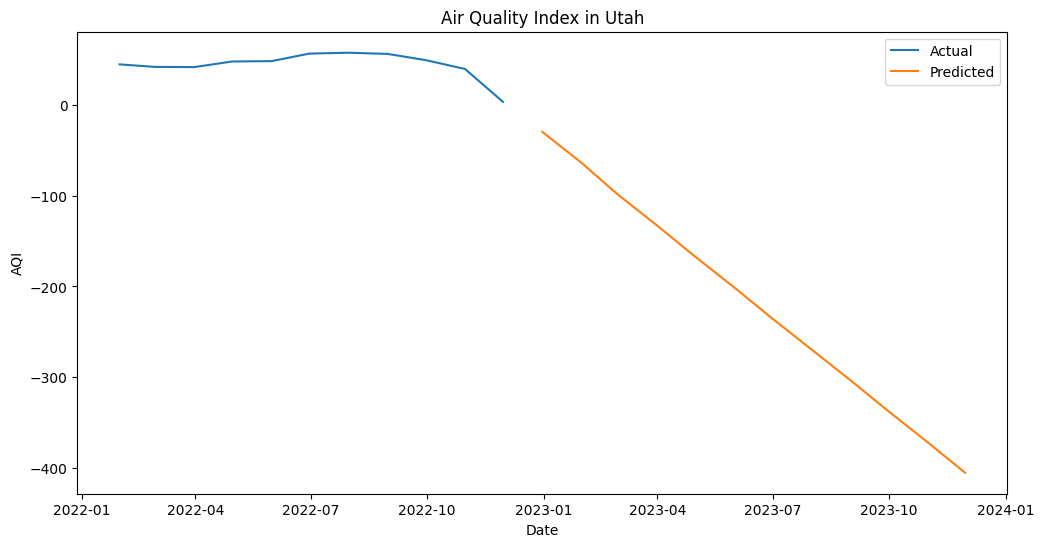

In [19]:
# Import necessary libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Convert Date column to datetime format
df_22_ut['Date'] = pd.to_datetime(df_22_ut['Date'])

# Group by month and take mean AQI
df_utah_monthly = df_22_ut.resample('M', on='Date').mean()

# Fit the model to the data
model = ExponentialSmoothing(df_utah_monthly['AQI'], trend='add', seasonal=None)
fit = model.fit()

# Predict the next 12 months
pred = fit.forecast(12)

# Generate a visualization of the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(df_utah_monthly.index, df_utah_monthly['AQI'], label='Actual')
plt.plot(pred.index, pred.values, label='Predicted')
plt.legend()
plt.title('Air Quality Index in Utah')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()
